In [1]:
import numpy as np
import matplotlib.pyplot as plt
import  torch 
from torch import nn, optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import h5py

In [2]:
all_dataset = h5py.File("/content/drive/MyDrive/projects/neighbor/data/datasets.hdf5", "r")

X_train = np.array(all_dataset["train_set_X"])
y_train = np.array(all_dataset["train_set_y"])

X_val = np.array(all_dataset["val_set_X"])
y_val = np.array(all_dataset["val_set_y"])

X_test = np.array(all_dataset["eval_set_X"])
y_test = np.array(all_dataset["eval_set_y"])

In [3]:
print(X_train.shape, X_val.shape, X_test.shape)

(3000, 64, 64, 3) (1000, 64, 64, 3) (1000, 64, 64, 3)


In [8]:
# 255値で正規化
X_train_norm = X_train / 255.0
X_val_norm = X_val / 255.0
X_test_norm = X_test / 255.0

In [4]:
class ImageDataset(Dataset):
    def __init__(self, x, y):
        super().__init__()
        
        self.x = torch.Tensor(x).permute(0,3,1,2).float() #NCHW -> NHWC
        self.y = torch.Tensor(y).type(torch.LongTensor)
               
    def __len__(self):
        return len(self.x)
    
    def __getitem__(self, index):
        image = self.x[index] / 255.0
        target = self.y[index]
        
        return image, target

In [6]:
BATCH_SIZE = 32

train_dataloader = DataLoader(ImageDataset(X_train, y_train), batch_size=BATCH_SIZE, shuffle=True, drop_last = True)
val_dataloader = DataLoader(ImageDataset(X_val, y_val), batch_size=BATCH_SIZE, shuffle=True, drop_last = True)
test_dataloader = DataLoader(ImageDataset(X_test, y_test), batch_size=BATCH_SIZE, shuffle=True, drop_last = True)

dataloaders_dict = {'train': train_dataloader, 'val': val_dataloader}

In [7]:
# 入力画像は(64, 64)の3チャンネル
model = nn.Sequential(
    nn.ZeroPad2d(padding=3),
    #入力チャンネル数, 出力チャンネル数,(フィルタの数) フィルタ(カーネル)の長さ
    nn.Conv2d(3, 64, 11, stride=1), # フィルタ64枚で、カーネルサイズは11にしたい
    nn.BatchNorm2d(64), # 入力チャンネル数
    nn.ReLU(),
    nn.MaxPool2d(2, stride=2),

    nn.Conv2d(64, 64, 2, stride=1),
    nn.BatchNorm2d(64),
    nn.ReLU(),
    nn.MaxPool2d(2, stride=2),

    nn.Conv2d(64, 64, 2, stride=1),
    nn.BatchNorm2d(64),
    nn.ReLU(),
    nn.MaxPool2d(2, stride=2),

    nn.Flatten(),
    nn.Linear(2304, 2)
)

In [8]:
n_epoch = 10
lr = 2e-4

opt = optim.Adam(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

In [9]:
def train_model(model, criterion, optimizer, num_epochs=10):
    
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    print(device)
    model.to(device)

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0 # epochの損失和
            running_corrects = 0 # epochの正解数

            for inputs, labels in dataloaders_dict[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                #学習フェーズならパラメータ更新
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            
            epoch_loss = running_loss / len(dataloaders_dict[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders_dict[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

    return model

In [10]:
model = train_model(model, criterion, opt, n_epoch)

cuda:0
Epoch 0/9
----------
train Loss: 0.4319 Acc: 0.7893
val Loss: 0.4988 Acc: 0.7530
Epoch 1/9
----------
train Loss: 0.3021 Acc: 0.8607
val Loss: 0.4825 Acc: 0.7870
Epoch 2/9
----------
train Loss: 0.2396 Acc: 0.8940
val Loss: 0.2955 Acc: 0.8750
Epoch 3/9
----------
train Loss: 0.2182 Acc: 0.9033
val Loss: 0.3056 Acc: 0.8680
Epoch 4/9
----------
train Loss: 0.1697 Acc: 0.9317
val Loss: 0.3524 Acc: 0.8330
Epoch 5/9
----------
train Loss: 0.1448 Acc: 0.9417
val Loss: 0.4914 Acc: 0.8200
Epoch 6/9
----------
train Loss: 0.1271 Acc: 0.9523
val Loss: 0.3084 Acc: 0.8810
Epoch 7/9
----------
train Loss: 0.1101 Acc: 0.9547
val Loss: 0.3826 Acc: 0.8440
Epoch 8/9
----------
train Loss: 0.0852 Acc: 0.9687
val Loss: 0.4491 Acc: 0.8400
Epoch 9/9
----------
train Loss: 0.0701 Acc: 0.9770
val Loss: 0.3156 Acc: 0.8720


In [23]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)
model.eval()
model.to(device)

epoch_corrects = 0
predictions = []
targets = []
for inputs, labels in (test_dataloader):
  inputs = inputs.to(device)
  labels = labels.to(device)

  with torch.set_grad_enabled(False):
     outputs = model(inputs)
     _, preds = torch.max(outputs, 1)
     predictions.extend(preds.to('cpu').detach().numpy().copy())
     targets.extend(labels.to('cpu').detach().numpy().copy())
     epoch_corrects += torch.sum(preds == labels.data)

epoch_acc = epoch_corrects.double() / len(test_dataloader.dataset)
print('Acc: {:.4f}'.format(epoch_acc))

cuda:0
Acc: 0.8490


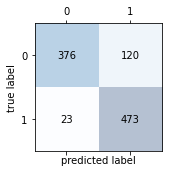

Precision：0.7976391231028668.
Recall：0.9536290322580645.


In [25]:
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

confmat = confusion_matrix(y_true=targets, y_pred=predictions)
fig, ax = plt.subplots(figsize=(2.5, 2.5))
ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)

for i in range(confmat.shape[0]):
  for j in range(confmat.shape[1]):
    ax.text(x=j, y=i, s=confmat[i, j], va='center', ha='center')

plt.xlabel('predicted label')
plt.ylabel('true label')
plt.tight_layout()
plt.show()

precision = precision_score(targets, predictions)
recall = recall_score(targets, predictions)
print(f'Precision：{precision}.')
print(f'Recall：{recall}.')